In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.is_available()
print(device)

cuda


In [3]:
df = pd.read_csv("rating_complete.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [5]:
df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [6]:
df['user_id'].describe()

count    5.763328e+07
mean     1.768878e+05
std      1.020117e+05
min      0.000000e+00
25%      8.827800e+04
50%      1.772910e+05
75%      2.654190e+05
max      3.534040e+05
Name: user_id, dtype: float64

In [7]:
df['anime_id'].describe()

count    5.763328e+07
mean     1.583147e+04
std      1.326114e+04
min      1.000000e+00
25%      3.091000e+03
50%      1.188700e+04
75%      2.899900e+04
max      4.845600e+04
Name: anime_id, dtype: float64

In [8]:
df.user_id.nunique()

310059

In [9]:
df.anime_id.nunique()

16872

In [10]:
df.rating.value_counts() #check value distribution

8     14642156
7     13325549
9      9773857
6      6849293
10     6716048
5      3436250
4      1455102
3       696048
2       405556
1       333419
Name: rating, dtype: int64

In [11]:
df.shape

(57633278, 3)

#### Training Dataset Class Wrapper

In [12]:
class AnimeDataset:
    def __init__(self, users, animes, ratings):
        self.users = users
        self.animes = animes
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1] 
    def __getitem__(self, item):

        users = self.users[item] 
        animes = self.animes[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "animes": torch.tensor(animes, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

#### Create the model

In [13]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_animes):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.anime_embed = nn.Embedding(n_animes, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, animes, ratings=None):
        user_embeds = self.user_embed(users)
        anime_embeds = self.anime_embed(animes)
        output = torch.cat([user_embeds, anime_embeds], dim=1)
        
        output = self.out(output)
        
        return output

In [14]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_anime = preprocessing.LabelEncoder()
df.user_id = lbl_user.fit_transform(df.user_id.values)
df.anime_id = lbl_anime.fit_transform(df.anime_id.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = AnimeDataset(
    users=df_train.user_id.values,
    animes=df_train.anime_id.values,
    ratings=df_train.rating.values
)

valid_dataset = AnimeDataset(
    users=df_valid.user_id.values,
    animes=df_valid.anime_id.values,
    ratings=df_valid.rating.values
)


In [15]:
for i in range(5):  # Print the first 5 data points
    data_point = train_dataset[i]
    print(data_point)

print(len(train_dataset))
print(len(valid_dataset))

{'users': tensor(211007), 'animes': tensor(13830), 'ratings': tensor(7)}
{'users': tensor(123627), 'animes': tensor(3532), 'ratings': tensor(9)}
{'users': tensor(40441), 'animes': tensor(9151), 'ratings': tensor(1)}
{'users': tensor(251116), 'animes': tensor(20), 'ratings': tensor(9)}
{'users': tensor(85875), 'animes': tensor(7254), 'ratings': tensor(5)}
51869950
5763328


In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          shuffle=True)

validation_loader = DataLoader(dataset=valid_dataset,
                               batch_size=16,
                               shuffle=True)

dataiter = iter(train_loader)
dataloader_data = next(dataiter)
print(dataloader_data)
print(len(train_loader))
print(len(validation_loader))

{'users': tensor([166877, 277488, 288304, 308458, 128366, 109380, 280424, 138945,  57393,
         56972,  70715, 271604, 102473, 251020, 296306, 306572]), 'animes': tensor([ 2726,  1390,  5362, 14878,  1563,  6454,  6186,  9596,  6655, 14774,
        10432, 12269,  8769,   427, 12390,  4706]), 'ratings': tensor([ 9,  7,  9,  9,  8,  7,  5,  9,  7,  8,  4,  6, 10, 10,  7,  8])}
3241872
360208


In [17]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_animes=len(lbl_anime.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [18]:
print(len(lbl_user.classes_))
print(len(lbl_anime.classes_))
print(df.anime_id.max())
print(len(train_dataset))

310059
16872
16871
51869950


#### Manually run a forward path

In [19]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['animes'] )
print(dataloader_data['animes'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
anime_embed = nn.Embedding(len(lbl_anime.classes_), 32)

out = nn.Linear(64, 1)

tensor([272507, 149269,  12222, 296236, 308496, 124351, 174060, 245343, 225765,
        196515,  56848,  74506, 161185,    175, 282158, 287097])
torch.Size([16])
tensor([ 5352, 14987,   437,   262,  8291,  3568,  3766,  6207,   195,  9114,
         1597,  5421,   872,   240,   769,  3532])
torch.Size([16])


In [20]:
user_embeds = user_embed(dataloader_data['users'])
anime_embeds = anime_embed(dataloader_data['animes'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"anime_embeds {anime_embeds.size()}")
print(f"anime_embeds {anime_embeds}")

user_embeds torch.Size([16, 32])
user_embeds tensor([[-1.2317,  1.4110, -0.0685, -0.7825, -0.9737, -0.1937,  0.9396, -0.0400,
          1.2122, -0.2325,  1.5533, -1.0296, -0.2544,  0.5883,  1.0825, -0.4169,
          0.9851,  0.7222,  0.5181, -0.6225,  0.2406, -0.6369, -0.1221, -1.7860,
         -0.4391,  1.5413,  0.8020,  0.6736,  0.5520, -0.6639, -0.0322, -1.2943],
        [ 1.8615, -0.7300,  0.6973, -1.4270, -0.6788,  0.3139, -0.4501, -0.1560,
          0.9526, -0.8024,  0.2790, -0.5165, -0.8028,  0.7726,  0.3439,  0.7327,
          0.5700,  0.6209,  1.7640, -1.8244,  0.3763,  0.0505, -0.2243,  0.4779,
         -0.0750, -0.9353,  1.5212, -1.1957,  0.7948,  0.2950,  0.5920, -0.3732],
        [-1.3486,  0.4231, -0.6200,  0.0329, -0.0113,  0.8482, -1.7171, -0.0640,
         -0.6275, -0.6592, -0.0805,  0.6986, -0.2692, -1.3043, -1.8007, -0.0058,
         -0.7021,  0.3909,  0.0413,  1.5852,  1.1118,  0.2439,  0.8091, -0.4838,
          1.0671, -0.6667, -0.3921,  1.3463,  0.1974,  0.7590,

In [21]:
output = torch.cat([user_embeds, anime_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([16, 64])
output: tensor([[-1.2317,  1.4110, -0.0685,  ..., -0.1066,  1.1296,  0.6700],
        [ 1.8615, -0.7300,  0.6973,  ..., -0.5289,  0.9906, -0.0798],
        [-1.3486,  0.4231, -0.6200,  ..., -1.5720,  0.4038,  0.1898],
        ...,
        [-1.4960,  0.3395,  0.7230,  ...,  0.2204, -1.3721, -0.4845],
        [ 0.6470,  0.0337, -0.7845,  ...,  0.5048,  0.2624,  1.9435],
        [-1.0554, -1.3812, -1.1865,  ...,  1.6926, -0.3298,  1.2977]],
       grad_fn=<CatBackward0>)
output: tensor([[-0.2841],
        [ 0.5614],
        [ 0.6206],
        [ 1.0563],
        [ 0.2930],
        [-0.4138],
        [ 1.4792],
        [ 0.4364],
        [ 0.7660],
        [ 0.4162],
        [ 0.8219],
        [-0.3708],
        [-0.3147],
        [ 0.2253],
        [-0.1950],
        [ 0.6349]], grad_fn=<AddmmBackward0>)


In [22]:
import torch

# Assuming you have a GPU available (cuda:0)
device = torch.device("cuda:0")

# Move the model to the GPU
model.to(device)

# Move the input tensors to the GPU
dataloader_data['users'] = dataloader_data['users'].to(device)
dataloader_data['animes'] = dataloader_data['animes'].to(device)

# Now you can use the model and input tensors together without any device mismatch error
with torch.no_grad():
    model_output = model(dataloader_data['users'], dataloader_data['animes'])
    print(f"model_output: {model_output}, size: {model_output.size()}")


model_output: tensor([[-0.0218],
        [-0.1191],
        [-0.4203],
        [ 0.5266],
        [-0.1632],
        [-0.4988],
        [-0.1370],
        [-0.2062],
        [-0.7646],
        [-0.5053],
        [-0.2419],
        [-0.5156],
        [ 0.2787],
        [-0.2777],
        [-0.5297],
        [ 0.6518]], device='cuda:0'), size: torch.Size([16, 1])


In [23]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(16, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([ 9,  6,  9,  7, 10,  7,  4,  6,  9,  8,  7,  8,  8,  7,  9,  9])
tensor([[ 9],
        [ 6],
        [ 9],
        [ 7],
        [10],
        [ 7],
        [ 4],
        [ 6],
        [ 9],
        [ 8],
        [ 7],
        [ 8],
        [ 8],
        [ 7],
        [ 9],
        [ 9]])
tensor([[-0.0218],
        [-0.1191],
        [-0.4203],
        [ 0.5266],
        [-0.1632],
        [-0.4988],
        [-0.1370],
        [-0.2062],
        [-0.7646],
        [-0.5053],
        [-0.2419],
        [-0.5156],
        [ 0.2787],
        [-0.2777],
        [-0.5297],
        [ 0.6518]], device='cuda:0')
tensor(123)
tensor(-125.9441, device='cuda:0')


#### Run the training loop

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined the model, loss function, and train_loader as mentioned before

# Initialize the optimizer and other parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

# Assuming you have a GPU available (cuda:0)
device = torch.device("cuda:0")
model.to(device)

model.train()

# Check if there is a saved checkpoint and load it
try:
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_batch = checkpoint['batch'] + 1
    step_cnt = start_batch * len(train_loader.dataset)
    all_losses_list = checkpoint['all_losses_list']
    print(f"Resuming training from epoch {start_epoch}, batch {start_batch}.")
except FileNotFoundError:
    start_epoch = 0
    start_batch = 0
    print("Starting training from scratch.")

for epoch_i in range(start_epoch, epochs):
    for i, train_data in enumerate(train_loader):

        # Check if the current batch should be skipped (before the last saved batch)
        if epoch_i == start_epoch and i < start_batch:
            continue

        # Move train_data to the GPU
        train_data = {key: value.to(device) for key, value in train_data.items()}

        output = model(train_data["users"], train_data["animes"])

        # .view(16, -1) is to reshape the rating to match the shape of model output which is 16x1
        rating = train_data["ratings"].view(16, -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])

        if step_cnt % plot_steps == 0:
            avg_loss = total_loss / (len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0  # reset total_loss
            
            # Save the model state and optimizer state dictionary
            checkpoint = {
                'epoch': epoch_i,
                'batch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'all_losses_list': all_losses_list,
            }
            torch.save(checkpoint, 'model_checkpoint.pth')


Starting training from scratch.
epoch 0 loss at step: 10000 is 0.4291927902698517
epoch 0 loss at step: 20000 is 0.33273335585594177
epoch 0 loss at step: 30000 is 0.22016685769557953
epoch 0 loss at step: 40000 is 0.14595111608505248
epoch 0 loss at step: 50000 is 0.10791743867695332
epoch 0 loss at step: 60000 is 0.0840874759376049
epoch 0 loss at step: 70000 is 0.06647205550521612
epoch 0 loss at step: 80000 is 0.052663810996711254
epoch 0 loss at step: 90000 is 0.04490258003473282
epoch 0 loss at step: 100000 is 0.037854665475338695
epoch 0 loss at step: 110000 is 0.03386905552074313
epoch 0 loss at step: 120000 is 0.02966891325227916
epoch 0 loss at step: 130000 is 0.026713013031333686
epoch 0 loss at step: 140000 is 0.025553504689782857
epoch 0 loss at step: 150000 is 0.02355481669008732
epoch 0 loss at step: 160000 is 0.022140823172032833
epoch 0 loss at step: 170000 is 0.020695349941030144
epoch 0 loss at step: 180000 is 0.020807942456379534
epoch 0 loss at step: 190000 is 0.02

RuntimeError: shape '[16, -1]' is invalid for input of size 14

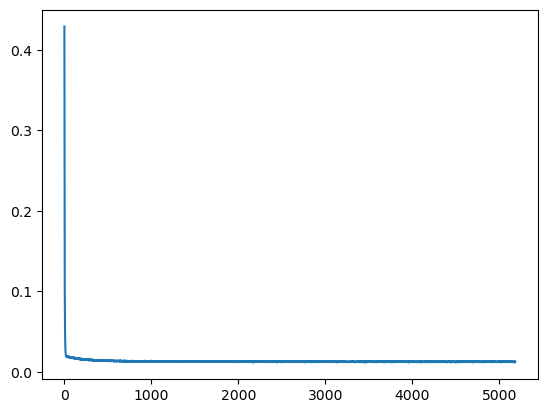

In [24]:
plt.figure()
checkpoint = torch.load('model_checkpoint.pth')
all_losses_list=checkpoint['all_losses_list']
plt.plot(all_losses_list)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

#checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#start_epoch = checkpoint['epoch']
#start_batch = checkpoint['batch'] + 1

model_output_list = []
target_rating_list = []
checkpoint = torch.load('model_checkpoint.pth')

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to('cuda'), batched_data["animes"].to('cuda'))
        model_output_list.append(model_output.sum().item() / len(batched_data['users']))

        target_rating = batched_data["ratings"].to('cuda')
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")

# Calculate RMSE on GPU
rms = mean_squared_error(torch.tensor(target_rating_list), torch.tensor(model_output_list), squared=False)
print(f"rms: {rms}")


model_output: tensor([[8.7333],
        [5.2887],
        [6.7422],
        [8.3097],
        [6.9457],
        [8.4615],
        [5.4904],
        [7.1500],
        [6.4647],
        [6.8130],
        [7.6534],
        [6.9146],
        [6.4542],
        [6.0424],
        [5.6600],
        [7.4085]], device='cuda:0'), target_rating: tensor([8, 4, 6, 9, 9, 8, 7, 9, 8, 8, 7, 7, 8, 5, 6, 8], device='cuda:0')
model_output: tensor([[8.6127],
        [7.1154],
        [7.3710],
        [9.6167],
        [7.3059],
        [7.0280],
        [7.2893],
        [6.7321],
        [8.7244],
        [7.2668],
        [5.9953],
        [6.5693],
        [8.1669],
        [9.9527],
        [7.7461],
        [8.8962]], device='cuda:0'), target_rating: tensor([10,  4,  8, 10,  8,  7,  7,  7,  9,  8,  6,  7, 10,  9,  8, 10],
       device='cuda:0')
model_output: tensor([[ 8.5032],
        [ 5.3866],
        [10.1308],
        [ 6.6596],
        [ 4.9109],
        [ 7.4196],
        [ 6.7644],
        [ 

In [ ]:
# ... (previous code)

# Move the model to the GPU
model.to('cuda:0')

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users'].to('cuda:0')  # Move users to the GPU
        animes = batched_data['animes'].to('cuda:0')  # Move animes to the GPU
        ratings = batched_data['ratings'].to('cuda:0')  # Move ratings to the GPU
        
        model_output = model(users, animes)

        for i in range(len(users)):
            user_id = users[i].item()
            anime_id = animes[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {anime_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating)) 


151054, 8631, 7.574688911437988, 8
175154, 2775, 6.555708408355713, 8
147761, 1428, 8.88027572631836, 10
60396, 8026, 6.994719505310059, 7
284642, 6042, 6.538417816162109, 8
121042, 162, 7.2846760749816895, 5
240396, 6640, 6.9455952644348145, 8
144257, 6955, 7.084441184997559, 10
224964, 11146, 7.2995686531066895, 7
6451, 470, 7.918684482574463, 8
123469, 3607, 6.817498683929443, 6
222620, 7099, 8.20699691772461, 10
257166, 10660, 8.654438018798828, 9
298499, 1717, 8.40721607208252, 8
103343, 14924, 6.740324974060059, 8
217155, 14431, 7.0597124099731445, 8
33111, 5732, 6.9445881843566895, 8
289364, 8291, 7.897064208984375, 9
95122, 3532, 9.084056854248047, 10
135068, 1067, 7.587360382080078, 6
239299, 536, 7.315022945404053, 8
291200, 2703, 8.370060920715332, 7
16059, 5524, 8.147459030151367, 9
289737, 8314, 7.482422828674316, 7
178630, 5557, 7.1511335372924805, 8
81434, 6622, 6.864778518676758, 7
54413, 8291, 8.921319961547852, 9
241576, 12275, 6.452275276184082, 7
214037, 6942, 7.169

In [22]:
# ... (previous code)

# Move the model to the GPU
model.to('cuda:0')

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users'].to('cuda:0')  # Move users to the GPU
        animes = batched_data['animes'].to('cuda:0')  # Move animes to the GPU
        ratings = batched_data['ratings'].to('cuda:0')  # Move ratings to the GPU
        
        model_output = model(users, animes)

        for i in range(len(users)):
            user_id = users[i].item()
            anime_id = animes[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            user_est_true[user_id].append((pred_rating, true_rating))

In [25]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [26]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")

precision @ 10: 0.993527176311586
recall @ 10 : 0.5227243683300292
